In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from hep_VQAE import data_preprocessing as dp
import tensorflow as tf
from pennylane.optimize import AdamOptimizer, GradientDescentOptimizer
import time

import warnings
warnings.filterwarnings('ignore')

2022-07-29 18:15:27.350292: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-29 18:15:27.350310: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# fix for lightning backed
tf.keras.backend.set_floatx('float64')

# Circuit

In [3]:
DATA_QBITS = 4
LATENT_QBITS = 2
TRASH_QBITS = DATA_QBITS - LATENT_QBITS
TOTAL_QBITS = DATA_QBITS + TRASH_QBITS + 1
LAYERS = 5

In [4]:
dev1 = qml.device('lightning.qubit', wires=TOTAL_QBITS)

In [5]:
@qml.qnode(dev1, diff_method='adjoint')
def circuit(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(DATA_QBITS))
    qml.BasicEntanglerLayers(weights, wires=range(DATA_QBITS))
    qml.Hadamard(wires=TOTAL_QBITS-1)
    for i in range(TRASH_QBITS):
        #c += cirq.ControlledGate(sub_gate=cirq.SWAP, num_controls=1).on(swap_qbit, reference_qbits[i], network_qbits[num_data_qbits - num_latent_qbits:][i])
        qml.CSWAP(wires=[TOTAL_QBITS - 1, LATENT_QBITS + i, DATA_QBITS + i])
    qml.Hadamard(wires=TOTAL_QBITS-1)
    return qml.expval(qml.PauliZ(TOTAL_QBITS-1))

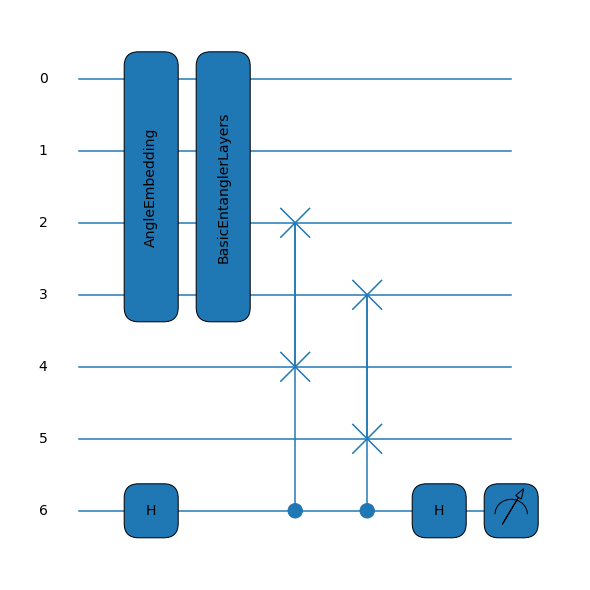

In [6]:
fig, ax = qml.draw_mpl(circuit)([0.1,0.24,0.3,0.14],[[1,1,1,1]])
fig.show()

# MNIST DATA

In [7]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train/255.0, x_test/255.0

In [8]:
def filter_36(x, y):
    keep = (y == 3) | (y == 6)
    x, y = x[keep], y[keep]
    y = y == 3
    return x,y

x_train, y_train = filter_36(x_train, y_train)
x_test, y_test = filter_36(x_test, y_test)

In [9]:
DOWNSCALE = 2
DATA_DIMENSION = DOWNSCALE*DOWNSCALE
LATENT_BITS = 2

x_train, x_test = dp.PCA_reduce(x_train, DATA_DIMENSION, val_data=x_test)

In [10]:
x_train_threes = np.array(x_train[y_train==True])
x_train = np.array(x_train[y_train==False])

x_test_threes = np.array(x_test[y_test==True])
x_test = np.array(x_test[y_test==False])

In [11]:
y_train = np.ones(x_train.shape[0])

# Training

In [12]:
weight_shapes = {"weights": (LAYERS, DATA_QBITS)}
params = np.random.uniform(size=weight_shapes["weights"], requires_grad=True)

In [13]:
qlayer = qml.qnn.KerasLayer(circuit, weight_shapes, output_dim=1)

In [14]:
inputs = tf.keras.layers.Input(shape=(4,))

In [15]:
model = tf.keras.models.Sequential([inputs, qlayer])

2022-07-29 18:15:29.257138: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-29 18:15:29.257182: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-29 18:15:29.257209: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (tomskopfbahnhof): /proc/driver/nvidia/version does not exist
2022-07-29 18:15:29.257479: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [16]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(opt, loss="mse")

In [17]:
es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=1,min_delta=0.0001)
fitting = model.fit(x_train, y_train, epochs=10, batch_size=64)

Epoch 1/10
13/93 [===>..........................] - ETA: 1:05 - loss: 0.3060


KeyboardInterrupt



In [ ]:
model.summary()